In [181]:
%matplotlib inline
%load_ext cython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from plotting_utils import label_sample, figure_path
import pandas as pd
import glob
import re
import os
from multiprocessing import Pool
import seaborn as sns
from matplotlib import rcParams
from sequencing_tools.viz_tools import color_encoder, okabeito_palette, simpsons_palette
from sklearn.preprocessing import LabelEncoder
from Bio import SeqUtils

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
%%cython
from collections import Counter, defaultdict
from operator import itemgetter
import re
from xopen import xopen

sc_re = re.compile('([0-9]+)S')
cdef soft_clip_base(cigar):
    s = sc_re.findall(cigar)
    s = map(int, s)
    return sum(s)

cpdef get_start(sample_folder):
    cdef:
        str line
        str chrom, start, end, strand, cigar
        list fields
        int sstart, send
    
    tRNA_regex = re.compile('^TR[A-Z]-|^MT')
    end_loc_counter = defaultdict(Counter)
    bed_file = sample_folder + '/count_temp/small_RNA.bed.gz'
    with xopen(bed_file) as bed:
        for line in bed:
            fields = line.strip().split('\t')
            chrom, start, end, strand, cigar = itemgetter(0,1,2,5, 6)(fields)
            sstart, send = int(start), int(end)
            
            is_tRNA = tRNA_regex.search(chrom)
            is_sense = strand == "+"
            good_alignment = soft_clip_base(cigar) < 10 
            not_fulllength = (send - sstart) < 50
            if is_tRNA and is_sense and good_alignment and not_fulllength:
                end_loc_counter[long(start)][long(end)] += 1
    return end_loc_counter

In [22]:
sample_folders = glob.glob('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/*001')
sample_folders = filter(lambda x: re.search('^[Qq][cC][fF][0-9]+|[qQ][cC][fF]_[pP]hos|[DE][ED]|Exo|[fF]rag|GC', os.path.basename(x)), 
                     sample_folders) 
sample_folders = list(sample_folders)

In [138]:
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/Counts/tsRNA.feather') \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(is_mt = lambda d: np.where(d.tRNA.str.startswith('MT'),'MT-',''))\
    .groupby(['anticodon','prep','samplename','frag_type','aa','is_mt'], as_index=False) \
    .agg({'frag_count':'sum'}) \
    .assign(frag_fraction = lambda d: 100*d.groupby(['samplename','prep','aa','anticodon','is_mt']).frag_count.transform(lambda x: x/x.sum()))\
    .assign(cpm = lambda d: d.groupby(['samplename','prep']).frag_count.transform(lambda x: 1e6*x/x.sum()))\
    .query('frag_type != "Others"')  \
    .assign(anticodon = lambda d: d.is_mt + d.aa +'-'+ d.anticodon) \
    .sort_values(['is_mt','aa']) \
    .assign(frag_type = lambda d: d.frag_type.str.replace('half','tRNA-half'))
df.head()

,anticodon,prep,samplename,frag_type,aa,is_mt,frag_count,frag_fraction,cpm
860,Ala-AGC,DNase I,QCF1_R1_001,3' tRNA-half,Ala,,28009,65.226706,5492.573583
861,Ala-AGC,DNase I,QCF1_R1_001,3' tsRNA,Ala,,246,0.572879,48.240676
862,Ala-AGC,DNase I,QCF1_R1_001,5' tRNA-half,Ala,,12,0.027945,2.353204
863,Ala-AGC,DNase I,QCF1_R1_001,Full-length,Ala,,12646,29.449710,2479.884520
865,Ala-AGC,DNase I,QCF2_R1_001,3' tRNA-half,Ala,,42996,60.516834,6269.055875


In [139]:
df.prep.unique()

array(['DNase I', 'DNase I + Exo I', "DNase I - 3'P", 'EV', 'Fragmented',
       'HEK293', 'High salt (450mM)', 'MNase EV', 'MNase EV+RNP',
       'MNase RNP', 'NaOH', 'RNP', 'RNP+EV', 'Untreated'], dtype=object)

In [162]:
prep = ['DNase I', "DNase I - 3'P",'HEK293']#, 'MNase RNP','MNase EV']#,"HEK293"]
tsRNA = ['Full-length',"3' tRNA-half", "5' tRNA-half", "3' tsRNA"]


In [175]:
def plot_fragments(df, y = 'frag_fraction', figurename='', no_mt = True):
    ylab = '% Reads' if y == 'frag_fraction' else 'CPM'
    mt = df.anticodon.str.contains('MT')
    if no_mt:
        df = df[~mt]
    anticodon = df.anticodon.unique().tolist()
    p = sns.FacetGrid(data = df.pipe(lambda d: d[d.prep.isin(prep)]), 
                col = 'frag_type', 
                col_wrap=1, 
                col_order = tsRNA,
                aspect=5,
                sharey=False)
    p.map(sns.swarmplot,
          'anticodon',
          y,
          'prep',
          alpha=0.6,
          hue_order = prep,
          order = anticodon,
          dodge=True,
          palette = sns.color_palette("muted")) #['#85a9e2','#f7cd62','red'])
    for ax in p.fig.axes:
        ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=70,
                      ha = 'right',
                      rotation_mode='anchor')
        for xt in ax.get_xticklabels():
            if xt.get_text().startswith('MT'):
                xt.set_color('purple')
    p.set_titles('{col_name}', size=20)
    p.add_legend(fontsize=15, bbox_to_anchor=(0.7,0.5))
    p.set_axis_labels('Anticodon', ylab)
    p.savefig(figurename, bbox_inches='tight')

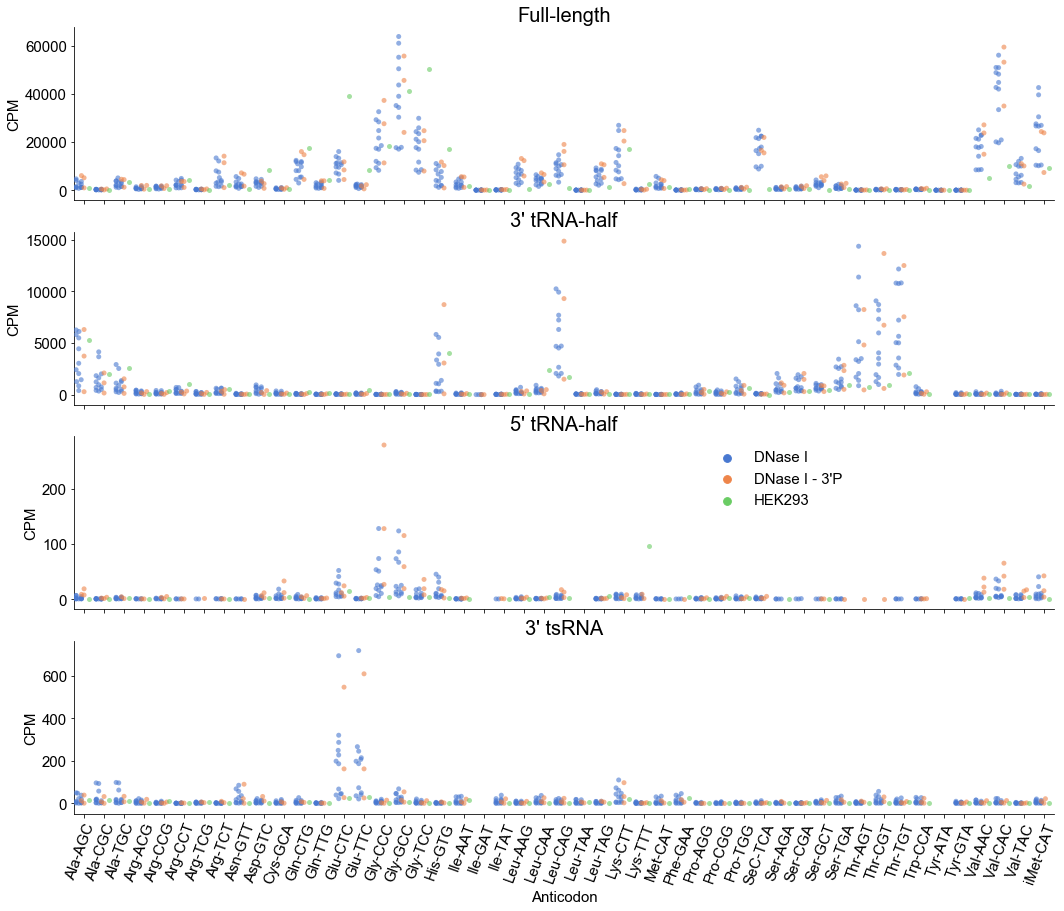

In [179]:
figurename = figure_path + '/tRNA_fragment_cpm.pdf'
plot_fragments(df , y = 'cpm', figurename = figurename)

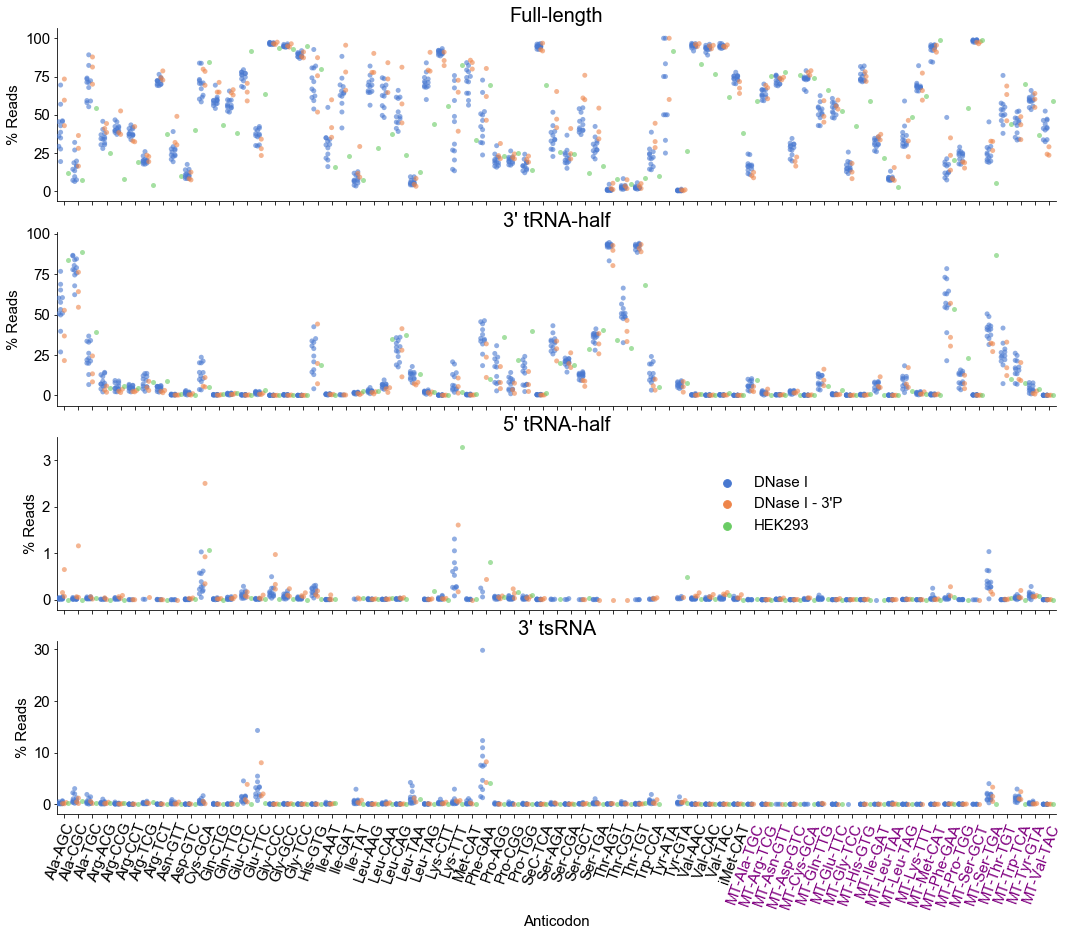

In [180]:
figurename = figure_path + '/tRNA_fragment_percentage.pdf'
plot_fragments(df , y = 'frag_fraction', figurename = figurename, no_mt=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


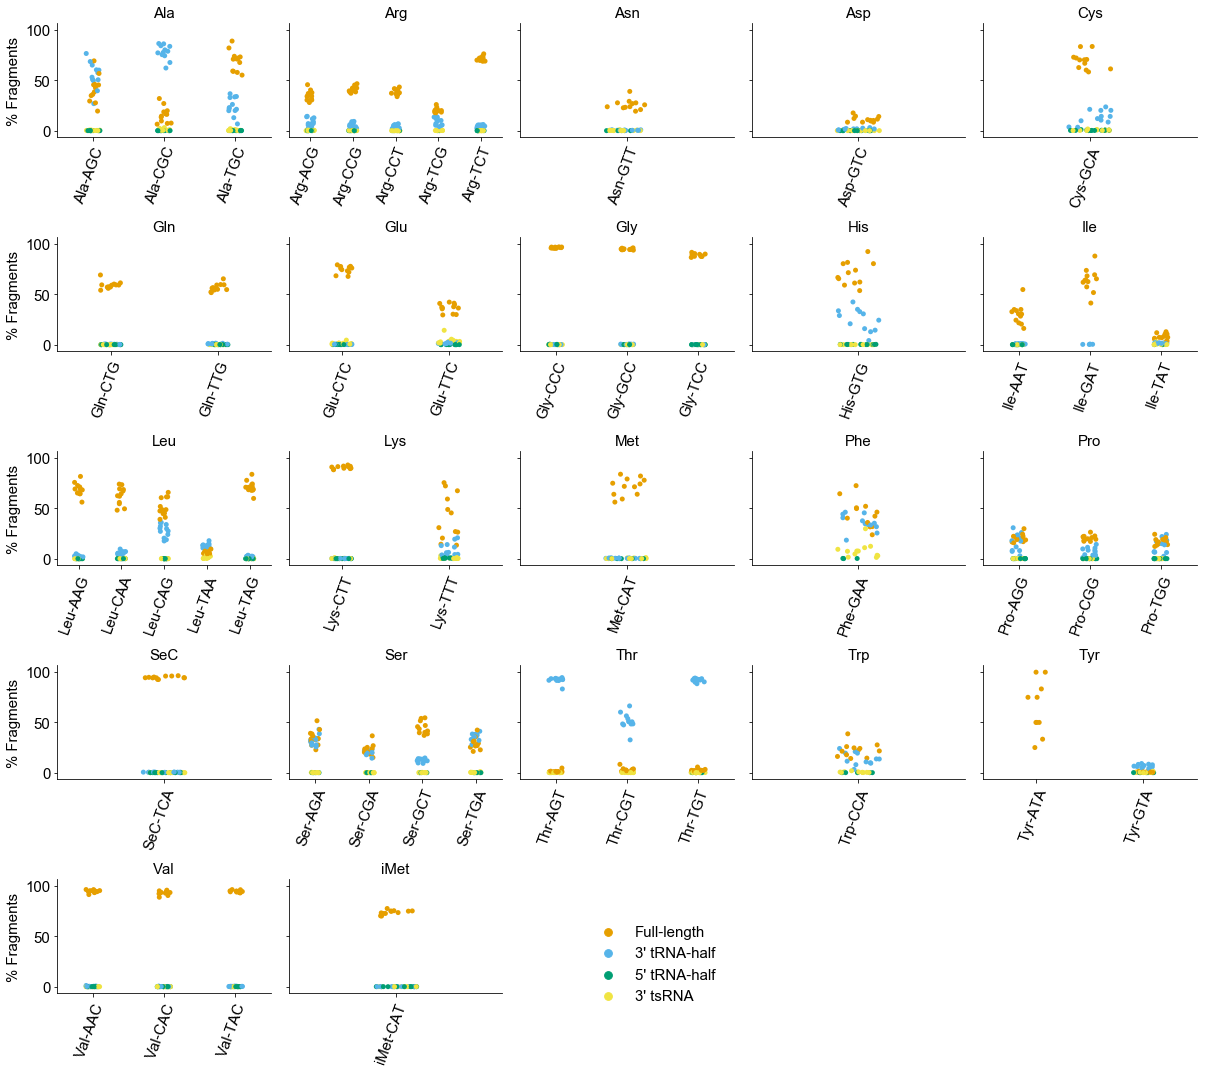

In [136]:
p = sns.FacetGrid(data = df \
        .query('prep == "DNase I"') \
        .pipe(lambda d: d[~d.anticodon.str.contains('MT')]),
    col = 'aa',
    aspect = 1,
    col_wrap = 5,
    sharex=False)
p.map(sns.stripplot,
    'anticodon',
    'frag_fraction',        
    'frag_type',
     hue_order = tsRNA,
     palette = okabeito_palette())
for ax in p.fig.axes:
    xts = ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=70,
                      ha = 'right',
                      rotation_mode='anchor')
p.add_legend(frameon=False,fontsize=15, bbox_to_anchor = (0.6,0.1))
p.set_axis_labels('','% Fragments')
p.set_titles('{col_name}')
figurename = figure_path + '/fragment_percentage.pdf'
p.fig.tight_layout()
p.savefig(figurename, bbox_inches='tight')